In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance 
import numpy as np
import seaborn as sns
from scipy.special import lambertw
import scipy.stats as stats
import warnings
import os 
from IPython.display import display
import matplotlib.image as mpimg
from config.config import (
                    NUMERIC_DATA_TYPES,
                    HORSES_DATA_IDS,
                    HORSES_DATA_PATH,
                    HORSES_DATA_PROCESSED_PATH,
                    LABEL_FONT,
                    TITLE_FONT,
                    FORECAST_PRICE_FEATURES,
                    STAT_ANALYSIS_FEATURES,
                    FORECAST_PRICE_SAMPLE_IDS,
                    STARTING_PRICE_FEATURES,
                    STARTING_PRICE_SAMPLE_IDS,
                    LAST_RUN_DAY_KEY_FEATURES,
                    JOCKEY_PERFORMANCE_COLUMNS,
                    HORSE_PERFORMANCE_COLUMNS,
                    IMAGE_FOLDER
)

from lib.lib import (
        check_duplicates,
        plot_discrete_histogram,
        plot_discrete_group_histogram,
        plot_continuous_histogram,
        plot_correlation_heatmap,
        boxplot,
        count_missing,
        month_string_to_month_number,
        calculate_profit_ratio,
        Colour
)


ModuleNotFoundError: No module named 'yfinance'

In [2]:
# Notebook Config
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.max_columns = None

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Load Data
* What is the overall data shape (rows, cols etc.)
* How have the columns been read into memory?
* Are the columns correctly typed?
* Which columns appear to be mistyped?
* Are there any obvious issues like empty columns, dates as floats etc.

In [4]:
# Load data into memory.
horses = pd.read_csv(HORSES_DATA_PATH)
print(horses.shape)
horses.head()

(36819, 24)


RaceID  HorseID  Cloth  Stall  WeightValue   JockeyID  TrainerID  \
0  989418  2963489      7    5.0          132  1398052.0    1198534   
1  989418  2972665     13    6.0          132  1165412.0    1188128   
2  989418  2972662      9    7.0          132  1239852.0    1199122   
3  989418  2960365      1   12.0          132  1417524.0    1049637   
4  989418  2968596     11    8.0          132  1354773.0    1140041   

   LastRunDaysFlat  Age  CheekPieces ForecastPrice  StatCourse  StatDistance  \
0             26.0  3.0          NaN        16-Jan         NaN           NaN   
1              NaN  3.0          NaN        20-Jan         NaN           NaN   
2              NaN  3.0          NaN        10-Jan         NaN           NaN   
3             33.0  3.0          NaN        07-Apr         NaN           NaN   
4             24.0  3.0          NaN        08-Jan         NaN           NaN   

  StartingPrice Sex Colour  YearBorn  MeetingID ScheduledTime  HorseCount  \
0        12-Jan   f      b       NaN      87048    ##########          13   
1          40/1   f      b       NaN      87048    ##########          13   
2           NaN   f      b       NaN      87048    ##########          13   
3        11-Oct   f      b       NaN      87048    ##########          13   
4           NaN   f      b       NaN      87048    ##########          13   

  Weather  Course_Distance MeetingDate  Won  
0  Cloudy             1312  02/05/2017    0  
1  Cloudy             1312  02/05/2017    0  
2  Cloudy             1312  02/05/2017    0  
3  Cloudy             1312  02/05/2017    1  
4  Cloudy             1312  02/05/2017    0

In [5]:
# What types have been assigned? Are there any all missing (empty) columns?
horses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36819 entries, 0 to 36818
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RaceID           36819 non-null  int64  
 1   HorseID          36819 non-null  int64  
 2   Cloth            36819 non-null  int64  
 3   Stall            36615 non-null  float64
 4   WeightValue      36819 non-null  int64  
 5   JockeyID         36818 non-null  float64
 6   TrainerID        36819 non-null  int64  
 7   LastRunDaysFlat  34300 non-null  float64
 8   Age              36616 non-null  float64
 9   CheekPieces      0 non-null      float64
 10  ForecastPrice    35092 non-null  object 
 11  StatCourse       8832 non-null   float64
 12  StatDistance     7128 non-null   float64
 13  StartingPrice    32009 non-null  object 
 14  Sex              36814 non-null  object 
 15  Colour           36814 non-null  object 
 16  YearBorn         5160 non-null   float64
 17  MeetingID   

In [6]:
### All values for ScheduledTime are "##########" so effectively empty.
print(horses.ScheduledTime.sample(5))
horses.ScheduledTime.all()

29470    ##########
26069    ##########
27343    ##########
3767     ##########
24589    ##########
Name: ScheduledTime, dtype: object


True

##### What data structure best describes the dataset?
* <u>Cross-sectional: **NO**</u>
    * Dataset contains a non-empty Date (MeetingDate).
    * Therefore, observations occur at different times (time-dimension).


* <u>Time-series: **NO**</u>
    * There are five IDs. Unlikely dataset refers to a single unit observed over time.


* <u>Pooled cross-section: **Likely**</u>
    * multiple units under observation at different times.
    * Doesn't initially seem like units are observed continuously.


* <u>Panel data: **Possible**</u>
    * Unit under observation must be defined.
    * Then we can determine whether its observed continuously over dataset.

##### What's evident from the datatype summary?
* CheekPieces is empty and can be dropped during processing.
* ScheduledTime contains only #####, so it is effectively empty, and we drop it during preprocessing.
* Around half of the columns have missing values.
   * StatCourse and Yearborn are mostly missing values.
* MeetingDate is not being read into pandas as a date.
   * This needs to be corrected as it's the only apparent date in the dataset
* JockeyID read in as float, not int (like other 'ID') cols.
    * This is probably due to missing value (standard PD ints can't be NaN). Fix later.


### Section 2: Domain Research Review

##### Sources
* [racing explained-1](https://www.racingexplained.co.uk/)
* [racing-post-1](https://www.racingpost.com/guide-to-racing/horse-racing-terms/)
* [racing-post-2](https://www.racingpost.com/news/its-sad-one-of-them-had-to-lose-mcconnell-saddles-one-two-in-feature-race/512106)
* [britannica](https://www.britannica.com/sports/horse-racing/The-modern-age-of-racing)
* [horseracing-sense](https://horseracingsense.com/why-do-some-race-horses-carry-weights/)
* [paddypower-1](https://news.paddypower.com/guides/2022/02/02/weight-cloth-horse-racing-guide-saddle)
* [paddypower-2](https://news.paddypower.com/guides/2022/02/01/why-horses-wear-cheekpieces-horse-racing)
* [cheltenham-guide](https://cheltenhamguides.com/age-sex-and-weight-in-horse-racing/)


##### Possible primary keys:
 * meeting-race-horse
 * meeting-race-jockey (jointly unique?)
 * See below for data structure image. 

##### What is a meet?
* A meeting is an organised event that occurs on a given day(s) and hosts multiple races.
* Meetings are often held at regular intervals (weekly, quarterly, annually).
* Meetings can contain races for different course types (flat, hurdle) and sex/age types
* MeetingID flags the meet.
    * Unclear initially whether this ID is unique to an event type ("Kentucky Derby")
    * or a single instance of an event ("Kentucky Derby 2018").
    * We can use the uniqueness and the MeetingDate to discover the answer.

##### What is a trainer?
* Trainers are similar to managers. However, they can be responsible for multiple horses.
    * Sometimes trainers manage their horses (stable)
    * Or are hired on behalf of an owner.
* Trainers (or the owners they represent) bring horses to the meet to run in one or more races.
    * We should expect to see multiple HorseIDs to one trainer.
    * We should also expect multiple HorseIDs from one trainer at one meeting.
    * It's also possible for trainers to submit >1 horse in the same race.

##### Races: Horses, Jockeys, Types etc.
* A horse is owned/managed by a trainer and ridden by a jockey during a race.
* Jockeys can ride different horses at different events as part of the relationship with the trainer/owner.
* Horses and Jockeys should only be included once in a race.
* It's unclear whether it's common for horses to be ridden multiple times at a meet.
* UK: largest race is Grand National (annual), with 40 horses. It may be able used to locate the dataset.
* US: largest races (triple crown)
    * Kentucky Derby: Annual, 20 horses.
    * Belmont Derby: Annual, 12 horses.
    * Preakness Stakes: Annual, 22 horses.

##### The role of Weight and Weight Adjustment.
* Horse racing uses a handicap system where horses are disadvantaged by adding weight.
* This is based on many factors to balance the odds;
    * Performance history: positively related to GPO/IRS scores based on previous placements
    * Jockey weight and performance: rookie jockeys are given less weight or more if underweight.
    * Sex: adjustments for horse sex. Female horses racing with men are given less weight to compensate.
    * Age: the guidance is inconsistent. 4.5 is considered a horse's peak racing age, with younger horses given less weight to compensate.
* Weight is set based on how many races the jockey and horse have won
* And adjustments for gender (adjusted down) and age (older horses adjusted up? not clear)

##### Horse Colour
* May be useful in locating datasets given different US and UK standards.

<u> UK </u>

According to Weatherbys, the company that administers British racing under contract to the British Horseracing Authority (BHA), the primary body colours in thoroughbred racehorses are bay, black, brown, chestnut and grey.

<u> US </u>

The American Jockey Club recognises the following colours for Thoroughbred registration: black, white, chestnut, grey/roan, bay (brown), and palomino. Additionally, Thoroughbreds can have white markings.

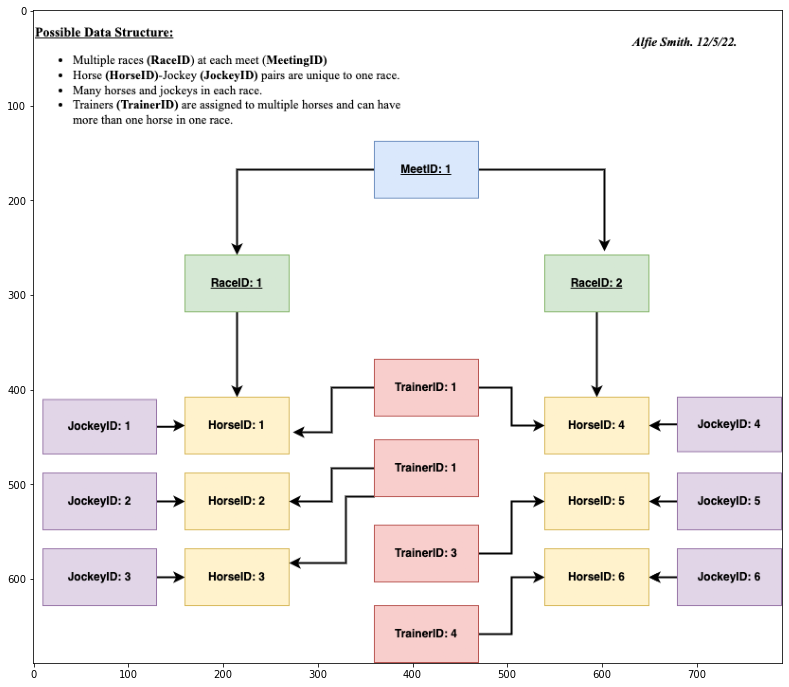

In [7]:
# Plotted using Python as using markdown was creating Latex issues when exporting. 
plt.figure(figsize=(14, 12))
img = mpimg.imread(os.path.join(IMAGE_FOLDER + "possible_data_structure.drawio.png"))
imgplot = plt.imshow(img)
plt.show()

## Section  3: Data Exploration

#### Overview
* **(I)** ID Analysis (are any of them a primary key?)
* **(II)** Meeting (MeetingID) analysis: do meetings match the literature review?
* **(III)** RaceID analysis: what is a race in this dataset?
* **(IV)** Creating a unique primary key for each observation.
* **(V)** Feature Analysis.

### Section (3.I) General 'ID' Column Analysis
*The primary key is a column value or set of column values that refer uniquely to a single unit under observation*

In [8]:
# Are any of the five variables with the ID flag unique?
# Are any columns with 'ID' flag unique? # None! All repeated. None individually are PKEY.

# Some ID flags read in a floats as they contain missing values. 'Int64' dtype can handle NA.
horses[HORSES_DATA_IDS] = horses[HORSES_DATA_IDS].astype('Int64')
for key in HORSES_DATA_IDS:
    check_duplicates(horses, [key])

CHECK DUPLICATES FAIL: 36819 Duplicated Rows Found For Columns ['RaceID']
CHECK DUPLICATES FAIL: 36779 Duplicated Rows Found For Columns ['JockeyID']
CHECK DUPLICATES FAIL: 36228 Duplicated Rows Found For Columns ['HorseID']
CHECK DUPLICATES FAIL: 36818 Duplicated Rows Found For Columns ['TrainerID']
CHECK DUPLICATES FAIL: 36819 Duplicated Rows Found For Columns ['MeetingID']


#### Section (3.I) Concluding Remarks:
* None of the columns with the 'ID' flag are remotely close to unique (almost all repeated).
* I suspect that some combination ID column values act as the PKey.
* Finding this uniquely identifying set will go a long way in determining the unit of observation.

### Section (3.II) Analysis of Meeting ID:
* Is Meeting ID unique to one date?
* Are there multiple races per meet?
* Are there multiple meets associated with the same race? (Hopefully not...)
* How often do meetings occur? What is the timeline in the dataset?

Earliest Meeting Date: 2017-05-02 00:00:00 Latest Meeting Date: 2018-02-07 00:00:00
There are 280 Meeting Dates
There are 0 Meetings With Missing Meeting Dates
Each Meet (MeetingID) refers to one date (MeetingDate) only

Races (RaceID) Occur at one Meet (MeetingID) only

Multiple Meetings Per Race. Races per Meet Value Distribution:


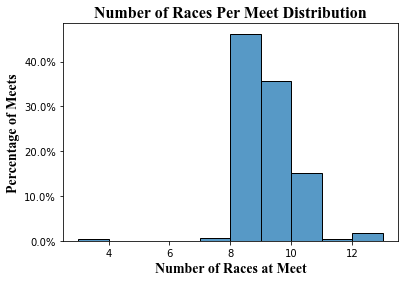

In [9]:
# When did the meets occur?
# Between 2017-05-02 and 2018-02-07
horses['MeetingDateDT'] = pd.to_datetime(horses.MeetingDate,
                                          format='%d/%m/%Y')
print("Earliest Meeting Date: {} Latest Meeting Date: {}".format(
    horses.MeetingDateDT.min(),
    horses.MeetingDateDT.max())
     )

# How many unique days does the dataset contain?
print("There are {} Meeting Dates".format(
    horses.MeetingDateDT.nunique())
     )

# Are we missing meeting dates for some events?
print("There are {} Meetings With Missing Meeting Dates".format(
    horses.MeetingDateDT.isna().sum())
     )

# Does meeting ID refer to the meeting type 'Cheltenam' or one occurence of 'Cheltenam'?
# Yes: Meeting refers to a specific meet on a given date
if horses.groupby('MeetingID').MeetingDate.nunique().max():
    print("Each Meet (MeetingID) refers to one date (MeetingDate) only")
else:
    print("Meets (MeetingID) cross multiple MeetingDates")

#Does a race always occur at the same meet?
# Yes! Seems that way,
if horses.groupby(['RaceID']).MeetingID.nunique().max() and \
   horses.groupby(['RaceID']).MeetingDate.nunique().max():
        print("\nRaces (RaceID) Occur at one Meet (MeetingID) only")
else:
        print("\nRaces (RaceID) found to occur at different Meetings (MeetingID)")

#Are there multiple 'races' at the same meet?
#Yes, the most is 13 races
print("\nMultiple Meetings Per Race. Races per Meet Value Distribution:")
plot_discrete_group_histogram(horses,
                              groupby_column='MeetingID',
                              summed_column='RaceID',
                              count_unique=True,
                              xlabel='Number of Races at Meet',
                              ylabel='Percentage of Meets',
                              hue=False,
                              title='Number of Races Per Meet Distribution')



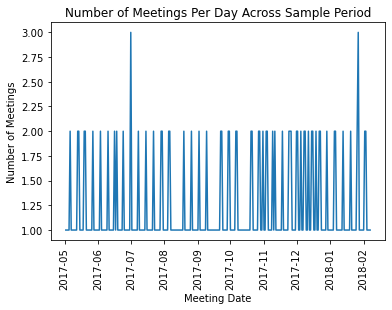

In [10]:
#What's the spread of meetings across dates? Some dates have multiple meets with max being 3
meetings_per_date = horses.groupby('MeetingDateDT').MeetingID.nunique().reset_index()

plt.plot(meetings_per_date.MeetingDateDT,
         meetings_per_date.MeetingID)
plt.xticks(rotation=90)
plt.title("Number of Meetings Per Day Across Sample Period")
plt.xlabel("Meeting Date")
plt.ylabel("Number of Meetings")
plt.show()

In [11]:
#Do horses run multiple races at same meet?
meetings_by_horse = horses.groupby(['MeetingID',
                                    'HorseID'])['MeetingDateDT'].count().reset_index()

print("{} Horses Ran More than Once at A Meet. \nMax number repeats: {}".format(
    meetings_by_horse[meetings_by_horse.MeetingDateDT>1].shape[0],
    meetings_by_horse.MeetingDateDT.max()
            )
     )

#Review a few horses that ran multiple times at same meet
display(horses[(horses.MeetingID==87562) & (horses.HorseID==2869170)])
display(horses[(horses.MeetingID==91572) & (horses.HorseID==2977520)])

151 Horses Ran More than Once at A Meet. 
Max number repeats: 2


RaceID  HorseID  Cloth  Stall  WeightValue  JockeyID  TrainerID  \
3688  993697  2869170      5   14.0          132   1165412    1079289   
3773  993700  2869170      5    NaN          132   1165412    1079289   

      LastRunDaysFlat  Age  CheekPieces ForecastPrice  StatCourse  \
3688             40.0  6.0          NaN        10-Jan         NaN   
3773              NaN  NaN          NaN           NaN         NaN   

      StatDistance StartingPrice Sex Colour  YearBorn  MeetingID  \
3688           NaN        28-Jan   g     ch    2011.0      87562   
3773           NaN          45/1   g     ch    2011.0      87562   

     ScheduledTime  HorseCount Weather  Course_Distance MeetingDate  Won  \
3688    ##########          15    Fine             1094  31/05/2017    0   
3773    ##########          15    Fine             2078  31/05/2017    0   

     MeetingDateDT  
3688    2017-05-31  
3773    2017-05-31

RaceID  HorseID  Cloth  Stall  WeightValue  JockeyID  TrainerID  \
36640  1028024  2977520      2   14.0          130   1472964    1188065   
36698  1028025  2977520      2    NaN          127   1472964    1188065   

       LastRunDaysFlat  Age  CheekPieces ForecastPrice  StatCourse  \
36640             28.0  4.0          NaN          33/1         NaN   
36698              NaN  NaN          NaN           NaN         NaN   

       StatDistance StartingPrice Sex Colour  YearBorn  MeetingID  \
36640           NaN        28-Jan   f      b       NaN      91572   
36698           NaN        14-Jan   f      b       NaN      91572   

      ScheduledTime  HorseCount Weather  Course_Distance MeetingDate  Won  \
36640    ##########          15   Sunny             1312  05/02/2018    0   
36698    ##########          17   Sunny             1531  05/02/2018    0   

      MeetingDateDT  
36640    2018-02-05  
36698    2018-02-05

#### Section (3.2) Concluding Remarks:

##### Relationship with MeetingDate variable.
* Meeting occurs on only one date, so Meeting ID likely refers to an event (GN 2018), not type.
* Data date range: May 2nd 2017, to Feb 7th 2018 (281 days, around nine months)
* 279 Unique Meeting Dates with Meets on almost every day in the date range.
* All Meets have a corresponding date (no missing dates).
* Most Meeting Dates have one meeting occurring on them. However, some have up to three.
* Meeting dates are non-contiguous for horses and jockeys. Therefore, unlikely that the dataset is a panel.
* As expected, races occur uniquely at one meet, and there are multiple races at one meeting

##### Relationship to Jockey and Trainer IDs:
* We have jockeys and trainers appearing multiple times at the same meet (expected).
* We also have horses appearing twice at the same meet.

##### Relationship to Horse ID:
* 151 horses ran twice at the same meet (7 observations).
* It's hard to know the order of the races as we only have a meeting date and not a time.
* Possible that the first race is a maiden race:
    * Maiden races are often used to test horses/give experience.
    * 1/2 races don't have a stall (NaN) which could indicate an unsupervised race.
* 151/6064 Horses (2.5%) run multiple races. Not a huge part of the dataset. It might not be a problem atm.

### Section (3.III) Analysis of Races (RaceID)
* How many horses per race?
* (From Section 2) Horses should only be listed once in a race.
* (From Section 2) It's possible that we'll see trainers with multiple horses in a race.
* (From Section 2) I expect jockeys (JockeyID) and horses (HorseID) to occur once per race
    * Jockeys don't tend to ride two horses at once!
    * A horse cannot enter twice and come 1st and 2nd.

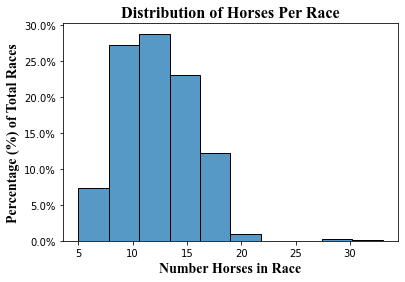

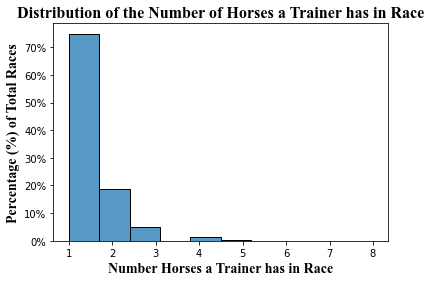

In [12]:
plot_discrete_group_histogram(horses,
                              groupby_column='RaceID',
                              summed_column='HorseID',
                              count_unique=True,
                              hue=False,
                              xlabel='Number Horses in Race',
                              ylabel='Percentage (%) of Total Races',
                              title='Distribution of Horses Per Race')
plt.show()

# What's the largest number of times a horses listed in the same race?
#Horses listed only once in all races
horses.groupby(['RaceID', 'HorseID']).size().max()

# Do trainers multiple horses in same race?
# Yes, but the number does seem odd as there are 109 races where trainer had 5+ horses in race.
plot_discrete_group_histogram(horses,
                              groupby_column=['RaceID', 'TrainerID'],
                              summed_column='HorseID',
                              count_unique=True,
                              hue=False,
                              xlabel='Number Horses a Trainer has in Race',
                              ylabel='Percentage (%) of Total Races',
                              title='Distribution of the Number of Horses a Trainer has in Race')
plt.show()

In [13]:
#Are jockeys listed as riding multiple times in same race?
#Yes, 348 jockeys listed twice in the same race (RaceID)!
print("Number of Times Jockey ID appears in a Race Value Distribution:")
jockey_duplicates = check_duplicates(horses, ['RaceID', 'JockeyID'])
display(horses.groupby(['RaceID', 'JockeyID']).HorseID.nunique().value_counts())

##Why are there jockeys that ride multiple times in same race?
KEY_FEATURES = ['MeetingDate',
                'Stall',
                'Won',
                'Course_Distance']
display(jockey_duplicates[HORSES_DATA_IDS + KEY_FEATURES].head(6))

Number of Times Jockey ID appears in a Race Value Distribution:
CHECK DUPLICATES FAIL: 705 Duplicated Rows Found For Columns ['RaceID', 'JockeyID']


1    36113
2      348
3        3
Name: HorseID, dtype: int64

RaceID  JockeyID  HorseID  TrainerID  MeetingID MeetingDate  Stall  Won  \
240  989644   1140012  2973010    1188090      87078  04/05/2017   13.0    0   
250  989644   1140012  2959450    1188090      87078  04/05/2017    1.0    0   
261  989645   1409974  2968270    1188090      87078  04/05/2017    1.0    0   
264  989645   1409974  2973011    1399453      87078  04/05/2017    3.0    0   
273  989646   1418973  2962992    1188128      87078  04/05/2017   15.0    0   
276  989646   1418973  2967957    1313151      87078  04/05/2017   14.0    0   

     Course_Distance  
240             1531  
250             1531  
261             1094  
264             1094  
273             1094  
276             1094

#### Section (3.III) Concluding Remarks:

##### What kind of 'Race' does RaceID reference?
* Dataset contains jockeys (JockeyID) that ride different horses (HorseID) in same race...
   * How can a Jockey ride two horses in 348 races and 3 horses in 3 races?
* Dataset contains trainers (TrainerID) that have 7+ horses in some races.
   * Trainers are allowed to submit >1 horse in races but 8 seems excessive!
   * Max I could find researching Kentucky Derby was 5 and Grand National 3 (biggest races).
   * 81 races where one trainer submitted 5 and 19 where they submitted 6.
* Data indicates same jockey ran the same race, same meet, with different horse.
* However, horse was in a different stall.
* In 2 cases the jockey won one of the races and lost the other one.

### Section (3.IV) Creating a Primary Key

##### Working Hypotheses (would confirm with domain expert).
1. 'Race' refers to a circuit or a type of race held at a meet not a singular race.
    * This could be a type of race -'flat/all-weather/hurdle'
    * Although better answer might be a racecourse.
    * Cheltenham's odds site has the same course listed multiple times on the same day.
    * May indicate that same course is being re-run with different horses (some repeated jockeys).

2. The unit of observation is an implied event. Let's call it a 'run'.
    * Run is a term used by some betting sites (hence 'also-ran').
    * The run refers to a set of 13-50 horses,
    * ridden by one jockey each
    * running a particular track (RunID) at a particular meet (MeetID).
    * Therefore, RaceID-HorseID-JockeyID should be jointly unique and act as PKEY.
    * Each row refers to one run of a racecourse with a set of 8-33 unique jockey-horse pair
    * The same racecourse can be run multiple times at the same meet

##### Working Data Hierarchy
**SEE BELOW**

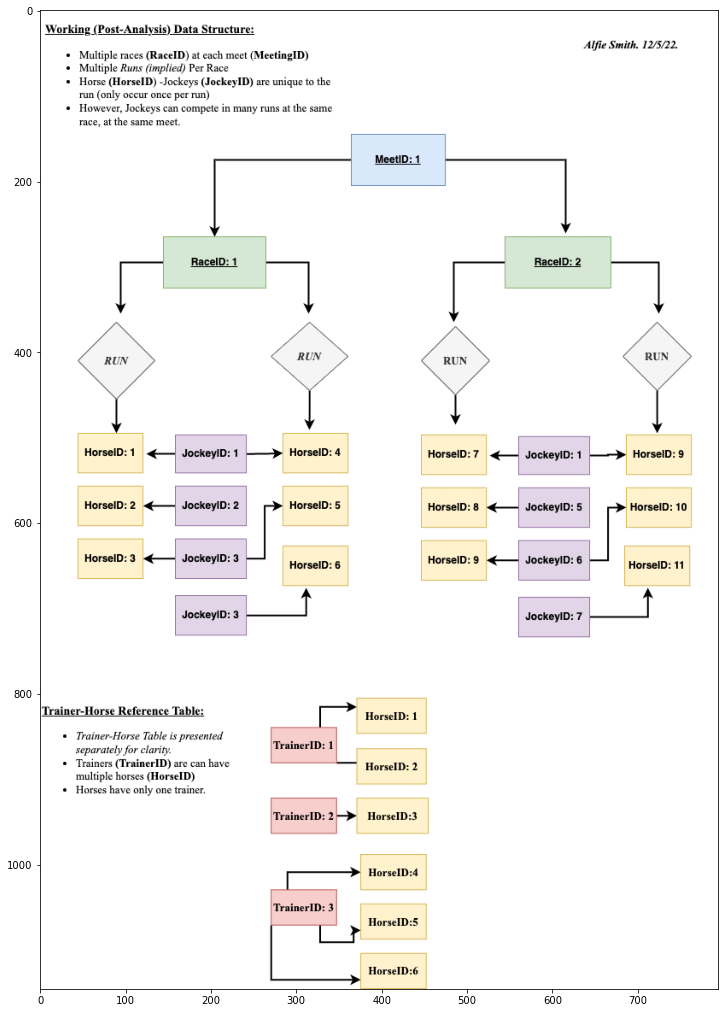

In [14]:
# Plotted using Python as using markdown was creating Latex issues when exporting. 
plt.figure(figsize=(16, 18))
img = mpimg.imread(os.path.join(IMAGE_FOLDER + "working_data_structure.drawio.png"))
imgplot = plt.imshow(img)
plt.show()

In [15]:
horses['PrimaryKey'] = horses.groupby(['RaceID','HorseID', 'JockeyID']).ngroup()

#Unique ID created, non-missing.
print("There are {} unique observations by the new primary key".format(
    horses.PrimaryKey.nunique())
     )
print("There are {} rows missing a primary key".format(
    horses.PrimaryKey.isna().sum())
     )
check_duplicates(horses, 'PrimaryKey')

There are 36819 unique observations by the new primary key
There are 0 rows missing a primary key
CHECK DUPLICATES PASS: No Duplicated Rows Found For Columns PrimaryKey


Empty DataFrame
Columns: [RaceID, HorseID, Cloth, Stall, WeightValue, JockeyID, TrainerID, LastRunDaysFlat, Age, CheekPieces, ForecastPrice, StatCourse, StatDistance, StartingPrice, Sex, Colour, YearBorn, MeetingID, ScheduledTime, HorseCount, Weather, Course_Distance, MeetingDate, Won, MeetingDateDT, PrimaryKey]
Index: []

In [16]:
# Happy that Pkey is acting as expected. Setting to dataframe object index
horses.set_index('PrimaryKey', drop=True, inplace=True)

#### Section (3.IV) Concluding Remarks:
* The RaceID-JockeyID-HorseID key satisfies all criteria of PKEY
    * The column is **unique**
    * The column is **complete** (no missing values)
    * The column **refers to the unit of observation** (assumed)

### Section (3.V): Feature Analysis

**Features to Explore**
* Sex and Colour.
* Age and Year of Birth.
* Weight and Cloth.
* LastRunFlat
* Weather
* Stall
* ForecastPrice and Starting Price
* StatCourse and StatDistance
* Won

### What sex and age range do we have for horses in the dataset?
#### Sex
* c: A male under five years old is called a Colt.
* h: male that turns five becomes a Horse.
* g: male that is castrated is called a Gelding.
* f: female under five years old is called a Filly.
* m: female that turns five becomes a Mare.

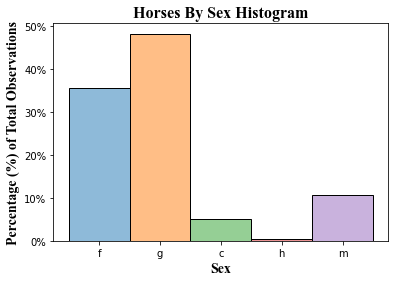

In [17]:
##Interesting, we have many geldings and fillies but few 'horses' aka adult males
plot_discrete_histogram(horses,
                        summed_column='Sex',
                        title='Horses By Sex Histogram')
plt.show()

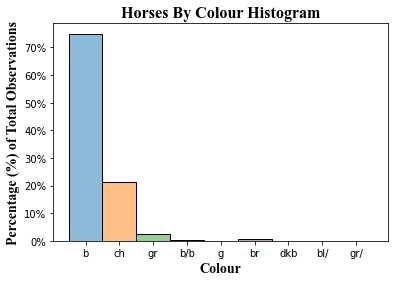

In [18]:
# Possible repeated colour labels (b/b, bl/, gr/)
# 94% Of distribution is just two colours black and ch (chesnut?)
plot_discrete_histogram(horses,
                        summed_column='Colour',
                        title='Horses By Colour Histogram')
plt.show()

#### Yearborn and Age

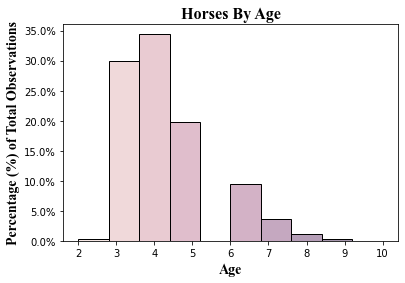

Year Born Missing For 31659 Rows
Age Missing For 203 Rows
Horse Age Distribution


4.0     12659
3.0     11021
5.0      7289
6.0      3506
7.0      1352
8.0       469
9.0       161
2.0       142
10.0       17
Name: Age, dtype: int64

In [19]:
plot_discrete_histogram(horses,
                        summed_column='Age',
                        title='Horses By Age',
                        hue=True)
plt.show()

print("Year Born Missing For {} Rows".format(
    horses.YearBorn.isna().sum()))

print("Age Missing For {} Rows".format(
    horses.Age.isna().sum()))

print('Horse Age Distribution')
display(horses['Age'].value_counts())

In [20]:
#Can we fill Yearborn by approximating by subtracting age from meeting date?
horses['YearBorn'] = horses.YearBorn.astype('Int64')
horses['YearBornProxy'] = (horses.MeetingDateDT -
                           pd.to_timedelta(horses.Age*365, unit='d')).dt.year.astype("Int64")

#Approximation works for 5139 but not for 21 horses (perhaps age incorrectly recorded or year-end issue)
incorrect_yearborn = horses[horses.YearBorn != horses.YearBornProxy]
print("YearBorn Approximation Failure Rate is {}%".format(
    (round(incorrect_yearborn.shape[0]/5160, 3))*100))

YearBorn Approximation Failure Rate is 0.4%


##### WeightValue Analyis
* Does WeightValue refer to the jockey/horse/handicap?

>>
In National Hunt racing the highest weight generally carried is 11st 12lbs and the lowest weight is typically 10st. In Flat racing the highest weight carried is usually around 10st 10lbs with the lowest possible weight 8st.
[Telegraph](https://www.telegraph.co.uk/betting/racing/what-is-a-handicap-in-horse-racing/)
>>

count    36819.000000
mean       126.604389
std          6.066849
min        101.000000
25%        122.000000
50%        128.000000
75%        132.000000
max        148.000000
Name: WeightValue, dtype: float64

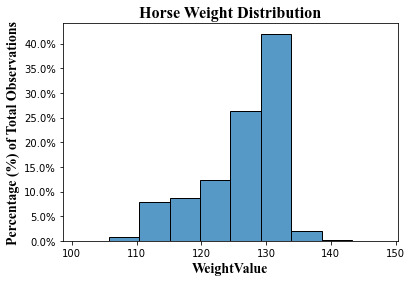

In [21]:
display(horses.WeightValue.describe())

# 75% WeightValue between 122-148 which fits closer to UK weight handicap than jockey/horse weight
# Median around 128 close to 132 UK standard.
plot_discrete_histogram(horses,
                        summed_column='WeightValue',
                        hue=False,
                        title='Horse Weight Distribution')

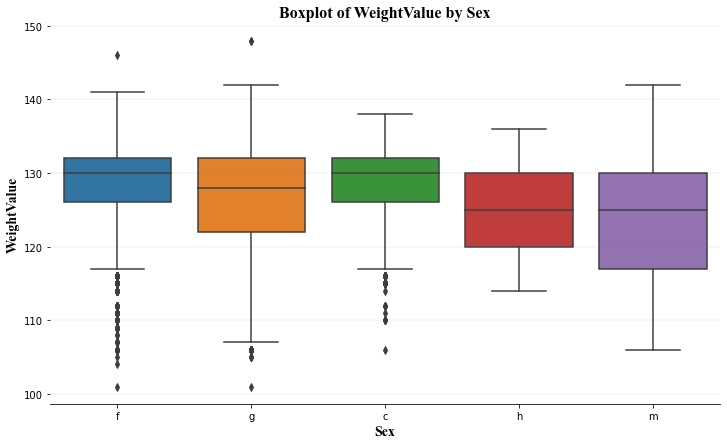

In [22]:
### Weight-Gender relationship: Is weight adjustment varying over horse sex
### fillies, geldings, colts similar (3-5y).
### Whereas, horses (5y+ male) and mares (5y+ female) have lower weight suggesting positive handicap
### Fillies and geldings have much larger spread of weight handicaps
boxplot(horses,
        'WeightValue',
        'Sex')

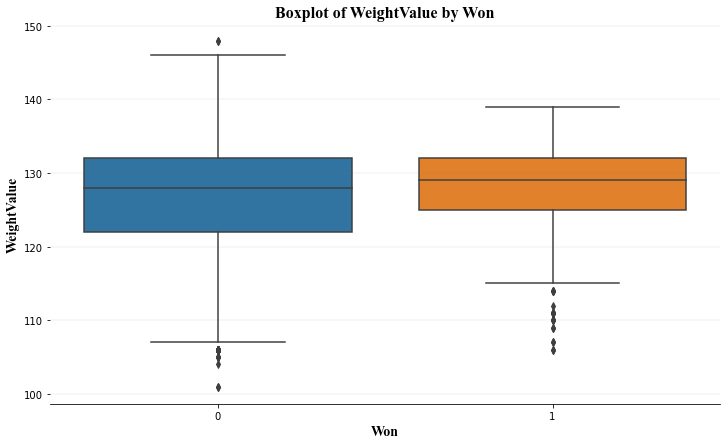

In [23]:
#### Winners tend to have more weight and sit within narrower bound
### Could be performance related or experience. Could be useful for modelling
boxplot(horses,
        'WeightValue',
        'Won')

##### Cloth Analysis
*What is cloth
* is it a weight cloth used as part of the weight adjustment?
* Or is it the number of their back?

<class 'pandas.core.series.Series'>
Int64Index: 36819 entries, 2 to 36810
Series name: Cloth
Non-Null Count  Dtype
--------------  -----
36819 non-null  int64
dtypes: int64(1)
memory usage: 1.6 MB


None

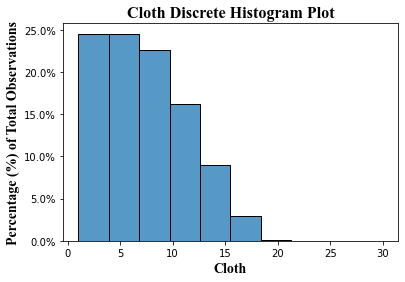

(3000, 3)
Races where number of cloth values != Horse Count: 25
Races where number of cloth values != Horse Count AND Horse Count != 0: 6


In [24]:
#Never missing. We would always expect a jockey to have a number
display(horses.Cloth.info())

#Most Races have 8-13 horses. Therefore, we'd expect to see a flat-ish distribution 1-13
plot_discrete_histogram(horses, 'Cloth', hue=False)
plt.show()

# Are there repeated Cloths in the same race? Is the number cloth values = HorseCount
cloth_per_race = horses.groupby('RaceID').agg(
     NumberClothValues = ('Cloth',
                          'nunique'),
     HorseCount = ('HorseCount',
                   'mean')
).reset_index()
print(cloth_per_race.shape)
cloth_per_race.head()

print("Races where number of cloth values != Horse Count: {}".format(
    cloth_per_race[cloth_per_race.NumberClothValues!=cloth_per_race.HorseCount].shape[0]
            )
     )

print("Races where number of cloth values != Horse Count AND Horse Count != 0: {}".format(
    cloth_per_race[
        (cloth_per_race.NumberClothValues!=cloth_per_race.HorseCount) &
        (cloth_per_race.HorseCount != 0)
                  ].shape[0]
            )
     )

#### Cloth notes
* When horse count data present in the data (!=0 or missing)
    * Cloth and HorseCount seem related as, in 98% of cases, the number cloth values in race = count.
    * If cloth does refer to the number on jockey back, then it's probably not useful for modelling
    * As its possible cloth is assigned in an arbitrary manner
    * Check with SME as it could be meaningful (similar to Football, Rugby etc.)

##### Last Run Flat
* Flat probably refers to types of race
* Steeple, Flat, Hurdle, All weather (astroturf) etc.
* Appears to be only flat given LastRunDaysFlat
* Common also for this figure to be given neg if last race not same type (US convention)
* All values are positive.

count    34300.000000
mean        37.663848
std         44.267732
min          1.000000
25%         16.000000
50%         25.000000
75%         42.000000
max        785.000000
Name: LastRunDaysFlat, dtype: float64


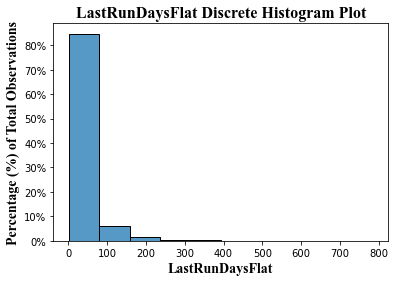

2519
       Age
count  5.0
mean   3.0
std    0.0
min    3.0
25%    3.0
50%    3.0
75%    3.0
max    3.0


In [25]:
# No negative (so that rules out the negative for diff race)
# Distribution seems reasonable av 37d with max at 2.2 years
print(horses.LastRunDaysFlat.describe())
plot_discrete_histogram(horses, 'LastRunDaysFlat', hue=False)

# Missing for 2519 entries. Could this mean its the horse fist race?
print(horses.LastRunDaysFlat.isna().sum())

# What kinds of horses are running with no prev race days (#All 3 years old)
first_runs = horses[horses.LastRunDaysFlat.isna()].head()
print(first_runs[['Age']].describe())

In [26]:
#Do horses with missing last run have a last run value later?
# Yes! Later meets have the
first_runs_complete = horses[horses.HorseID.isin(first_runs.HorseID)].copy()
first_runs_complete.sort_values(["HorseID", 'MeetingDateDT'],
                                inplace=True)
first_runs_complete ['MeetingDelta'] = (first_runs_complete['MeetingDateDT'] -
                                        first_runs_complete['MeetingDateDT'].shift()
                                       )

# Yes it matches Therefore, we can replace LastRunDaysFlat with 0.
first_runs_complete[LAST_RUN_DAY_KEY_FEATURES ].head(10)

# Therefore, we can be reasonably confident when creating a first race flag
horses['FirstRace'] = np.where(horses.LastRunDaysFlat.isna(), 1,0)


#### Forecast and Starting price
* seems to be a mix of dates and prices

##### Could it be that the stake has been repaced a month?
* Possible Examples:
    * 16-Jan is 16-1 as Jan is 1st month
    * 07-Apr is actually 07-4 as april is 4th month.
    * 11-Oct is 11-10 (even money) as Oct is 10th month.

* Possible implementations
    * Pandas string parsing: the 'date' odds have - while true odds have / so can probs split.
    * Regex solution: Would work. Can grab letters and avoid the actual num/num odds.
        * Issues - I want to avoid regex for sanity reasons if it can be helped.
    * Pandas Date parsing; Treat it as a date and grab the month.
        * Issues - no year, what abut the num/num odds

In [27]:
#57 unique values, currently a string. 1727 non null
count_missing(horses, ['ForecastPrice', 'StartingPrice'], sigfig=2)

print(horses['ForecastPrice'].describe())
print(horses['StartingPrice'].describe())

#This is odd, it's not the date of the meet (sometimes after).
horses[['MeetingDateDT','ForecastPrice', 'StartingPrice', 'Won']].head()

ForecastPrice missing: 1727 (5.0%) values
StartingPrice missing: 4810 (13.0%) values
count      35092
unique        57
top       20-Jan
freq        3691
Name: ForecastPrice, dtype: object
count      32009
unique        88
top       14-Jan
freq        1433
Name: StartingPrice, dtype: object


MeetingDateDT ForecastPrice StartingPrice  Won
PrimaryKey                                               
2             2017-05-02        16-Jan        12-Jan    0
12            2017-05-02        20-Jan          40/1    0
9             2017-05-02        10-Jan           NaN    0
1             2017-05-02        07-Apr        11-Oct    1
4             2017-05-02        08-Jan           NaN    0

In [28]:

# Split obs with values like '10-Jan' into a profit '10; [0] and stake Jan [1] in new cols
horses['ForecastPriceBet'] = horses.ForecastPrice.str.split("-").str[0]
horses['ForecastPriceStakeStr'] = horses.ForecastPrice.str.split("-").str[1]

# Convert the month into a number jan -1 april ->4
horses['ForecastPriceStakeNum'] = horses['ForecastPriceStakeStr'].apply(
    month_string_to_month_number).astype('Int64')

#Join the Profit and the stake together to get standard profit/stake strings for all rows
horses['ForecastPriceProxy'] = np.where(
    #When we were able to pull a month from the original forecated price (not na)
    horses.ForecastPriceStakeStr.notna(),

    # Use the retrieved month (converted to a number) to create the odds profit/stake
    horses.ForecastPriceBet.str.cat(
            others=horses['ForecastPriceStakeNum'].astype(str),
            sep='/'),

    # Else use the original price string value
    horses.ForecastPrice)

###Repeat for starting stake (use case for turning this into script?)
horses['StartingPriceBet'] = horses.StartingPrice.str.split("-").str[0]
horses['StartingPriceStakeStr'] = horses.StartingPrice.str.split("-").str[1]

horses['StartingPriceStakeNum'] = horses['StartingPriceStakeStr'].apply(
    month_string_to_month_number).astype('Int64')

horses['StartingPriceProxy'] = np.where(
    horses.StartingPriceStakeStr.notna(),
    horses.StartingPriceBet.str.cat(
            others=horses['StartingPriceStakeNum'].astype(str),
            sep='/'),
    horses.StartingPrice)

horses['StartingPriceProfitRatio'] = horses.StartingPriceProxy.apply(calculate_profit_ratio)
horses['ForecastPriceProfitRatio'] = horses.ForecastPriceProxy.apply(calculate_profit_ratio)

display(horses[horses.index.isin(FORECAST_PRICE_SAMPLE_IDS)][FORECAST_PRICE_FEATURES])
display(horses[horses.index.isin(STARTING_PRICE_SAMPLE_IDS)][STARTING_PRICE_FEATURES])

MeetingID ForecastPrice ForecastPriceBet ForecastPriceStakeStr  \
PrimaryKey                                                                   
1166            87214        12-Jan               12                   Jan   
4704            87696           NaN              NaN                   NaN   
7196            88008        07-Jan               07                   Jan   
11954           88631        25-Jan               25                   Jan   
18065           89503        12-Jan               12                   Jan   
19081           89632        11-Feb               11                   Feb   
23606           90201          33/1             33/1                   NaN   
23414           90200        25-Jan               25                   Jan   
23810           90229        20-Jan               20                   Jan   
35789           91477        07-Jan               07                   Jan   

            ForecastPriceStakeNum ForecastPriceProxy  ForecastPriceProfitRatio  
PrimaryKey                                                                      
1166                            1               12/1                      12.0  
4704                         <NA>                NaN                       NaN  
7196                            1               07/1                       7.0  
11954                           1               25/1                      25.0  
18065                           1               12/1                      12.0  
19081                           2               11/2                       5.5  
23606                        <NA>               33/1                      33.0  
23414                           1               25/1                      25.0  
23810                           1               20/1                      20.0  
35789                           1               07/1                       7.0

MeetingID StartingPrice StartingPriceBet StartingPriceStakeStr  \
PrimaryKey                                                                   
2               87048        12-Jan               12                   Jan   
1               87048        11-Oct               11                   Oct   
4               87048           NaN              NaN                   NaN   
3               87048        11-Aug               11                   Aug   
0               87048         100/1            100/1                   NaN   
1166            87214        08-Jan               08                   Jan   
18065           89503        20-Jan               20                   Jan   
35789           91477        03-Jan               03                   Jan   
36817           91584           NaN              NaN                   NaN   
36816           91584           NaN              NaN                   NaN   

            StartingPriceStakeNum StartingPriceProxy  StartingPriceProfitRatio  
PrimaryKey                                                                      
2                               1               12/1                     12.00  
1                              10              11/10                      1.10  
4                            <NA>                NaN                       NaN  
3                               8               11/8                      1.38  
0                            <NA>              100/1                    100.00  
1166                            1               08/1                      8.00  
18065                           1               20/1                     20.00  
35789                           1               03/1                      3.00  
36817                        <NA>                NaN                       NaN  
36816                        <NA>                NaN                       NaN

#####Stat Course and Distance

StatCourse missing: 27987 (76.0%) values
StatDistance missing: 29691 (81.0%) values
count    8832.000000
mean        1.614357
std         1.043961
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: StatCourse, dtype: float64


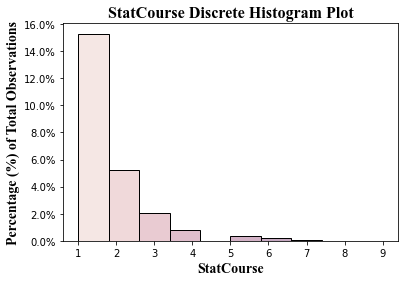

count    7128.000000
mean        1.494669
std         0.916141
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: StatDistance, dtype: float64


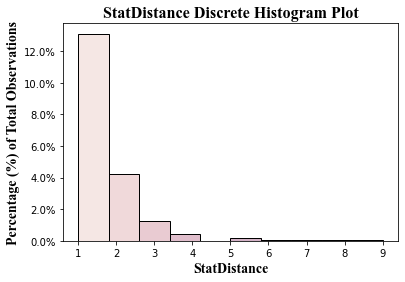

RaceID  HorseID  Cloth  Stall  WeightValue  JockeyID  TrainerID  \
PrimaryKey                                                                    
38          989421  2792219      1    5.0          132   1079247    1143892   
37          989421  2753530      8    2.0          125   1239852    1313151   
51          989422  2922526      2    8.0          131   1417524    1049637   
84          989425  2856030      5    8.0          125   1140012    1188090   
90          989425  2946189      1    3.0          132   1174081    1188113   

            LastRunDaysFlat  Age  CheekPieces ForecastPrice  StatCourse  \
PrimaryKey                                                                
38                     33.0  7.0          NaN          33/1         1.0   
37                     10.0  9.0          NaN        10-Jan         5.0   
51                     15.0  4.0          NaN        02-Jan         1.0   
84                     10.0  6.0          NaN        16-Jan         3.0   
90                     17.0  4.0          NaN        06-Apr         1.0   

            StatDistance StartingPrice Sex Colour  YearBorn  MeetingID  \
PrimaryKey                                                               
38                   2.0        18-Jan   g      b      2010      87048   
37                   1.0        09-Jan   g      b      2008      87048   
51                   1.0        11-Aug   g      b      <NA>      87048   
84                   1.0        10-Jan   g      b      2011      87048   
90                   1.0           NaN   c     ch      <NA>      87048   

           ScheduledTime  HorseCount Weather  Course_Distance MeetingDate  \
PrimaryKey                                                                  
38            ##########          10  Cloudy             1531  02/05/2017   
37            ##########          10  Cloudy             1531  02/05/2017   
51            ##########           8  Cloudy             1750  02/05/2017   
84            ##########          10  Cloudy             1094  02/05/2017   
90            ##########          10  Cloudy             1094  02/05/2017   

            Won MeetingDateDT  YearBornProxy  FirstRace ForecastPriceBet  \
PrimaryKey                                                                 
38            0    2017-05-02           2010          0             33/1   
37            0    2017-05-02           2008          0               10   
51            1    2017-05-02           2013          0               02   
84            0    2017-05-02           2011          0               16   
90            0    2017-05-02           2013          0               06   

           ForecastPriceStakeStr  ForecastPriceStakeNum ForecastPriceProxy  \
PrimaryKey                                                                   
38                           NaN                   <NA>               33/1   
37                           Jan                      1               10/1   
51                           Jan                      1               02/1   
84                           Jan                      1               16/1   
90                           Apr                      4               06/4   

           StartingPriceBet StartingPriceStakeStr  StartingPriceStakeNum  \
PrimaryKey                                                                 
38                       18                   Jan                      1   
37                       09                   Jan                      1   
51                       11                   Aug                      8   
84                       10                   Jan                      1   
90                      NaN                   NaN                   <NA>   

           StartingPriceProxy  StartingPriceProfitRatio  \
PrimaryKey                                                
38                       18/1                     18.00   
37                       09/1                      9.00   
51                      

In [29]:
count_missing(horses, ['StatCourse', 'StatDistance'], sigfig=2)

print(horses.StatCourse.describe())
plot_discrete_histogram(horses, 'StatCourse')
plt.show()

print(horses.StatDistance.describe())
plot_discrete_histogram(horses, 'StatDistance')
plt.show()

# Only 1804/36819 where both not null;
horses[(horses.StatCourse.notnull()) &
       (horses.StatDistance.notnull())].head()

#### Won (Label) Analysis
* Clear label as there is a return on investment inherent in picking winning horses
* Should be analysed in relation to the odds (negatively)
* There may also be segmental relationships with horses, jockeys and trainers
    * Some horses, jockeys and trainers win more than others.
    * This can create natural categories that may be useful for modelling
    * Should be careful not to capture future information into feature


Won missing: 0 (0.0%) values


0    92.10462
1     7.89538
Name: Won, dtype: float64

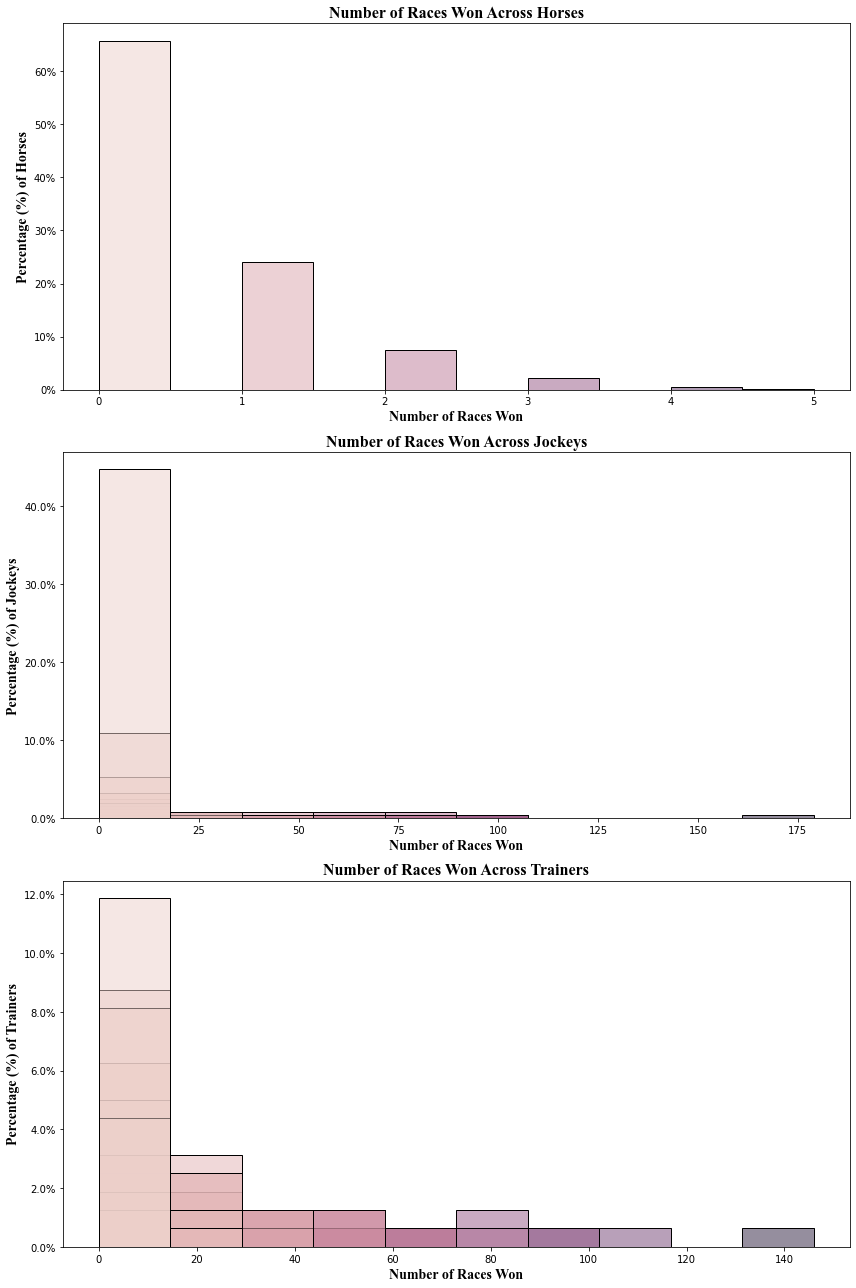

In [30]:
count_missing(horses, ['Won'])
# No labels missing. 7.9% of horses win which is very close to 1/13 (7.7%)
display(horses.Won.value_counts(normalize=True)*100)

fig, axarr = plt.subplots(3, 1, figsize=(12,18))

#1 The first subplot
plt.sca(axarr[0])

plot_discrete_group_histogram(horses,
                              'HorseID',
                              'Won',
                               xlabel='Number of Races Won',
                               ylabel='Percentage (%) of Horses',
                               title='Number of Races Won Across Horses',
                               show_plot=False)

plt.sca(axarr[1])
plot_discrete_group_histogram(horses,
                              'JockeyID',
                              'Won',
                               xlabel='Number of Races Won',
                               ylabel='Percentage (%) of Jockeys',
                               title='Number of Races Won Across Jockeys',
                               show_plot=False)

plt.sca(axarr[2])
plot_discrete_group_histogram(horses,
                              'TrainerID',
                              'Won',
                               xlabel='Number of Races Won',
                               ylabel='Percentage (%) of Trainers',
                               title='Number of Races Won Across Trainers',
                               show_plot=False)

fig.tight_layout()




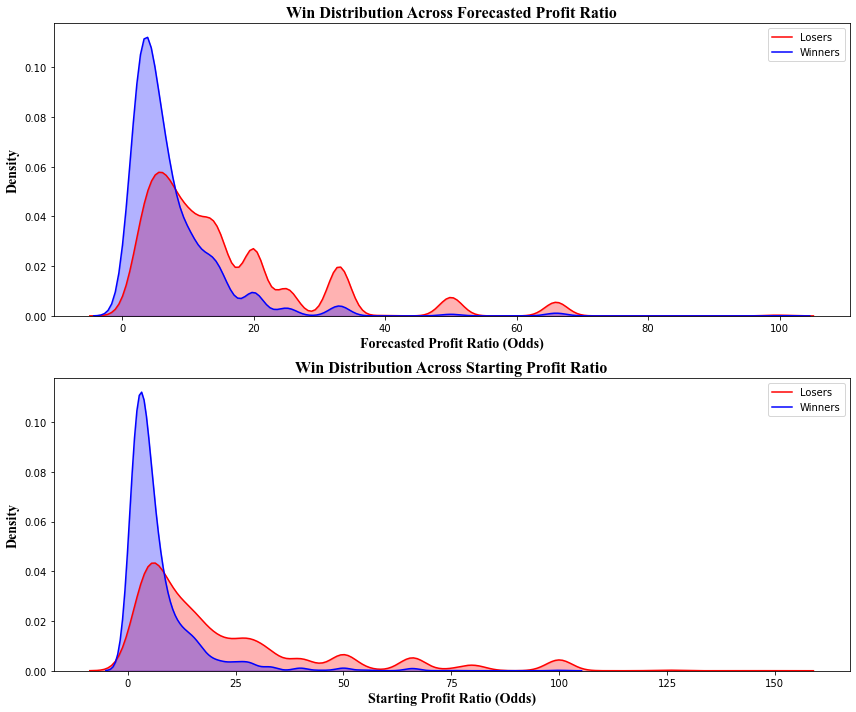

In [31]:
#### Win vs odds
fig, axarr = plt.subplots(2, 1, figsize=(12,10))

#1 The first subplot
plt.sca(axarr[0])

losers = horses[horses.Won == 0]
sns.distplot(losers['ForecastPriceProfitRatio'],
             kde=True,
             label='Losers',
             hist=False,
             color='red'
             )
winners = horses[horses.Won == 1]
sns.distplot(winners['ForecastPriceProfitRatio'],
             kde=True,
             label='Winners',
             hist=False,
             color='blue'
             )

# Plot formatting
plt.legend(prop={'size': 10})
plt.title('Win Distribution Across Forecasted Profit Ratio', fontdict=TITLE_FONT)
plt.xlabel('Forecasted Profit Ratio (Odds)', fontdict=LABEL_FONT)
plt.ylabel('Density', fontdict=LABEL_FONT)

# Get the two lines from the axes to generate shading
l1 = axarr[0].lines[0]
l2 = axarr[0].lines[1]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
axarr[0].fill_between(x1,y1, color="red", alpha=0.3)
axarr[0].fill_between(x2,y2, color="blue", alpha=0.3)

#1 The second subplot
plt.sca(axarr[1])

losers = horses[horses.Won == 0]
distplot = sns.distplot(losers['StartingPriceProfitRatio'],
                         kde=True,
                         label='Losers',
                         hist=False,
                         color='red'
                         )

winners = horses[horses.Won == 1]
sns.distplot(winners['StartingPriceProfitRatio'],
             kde=True,
             label='Winners',
             hist=False,
             color='blue'
             )

# Plot formatting
plt.legend(prop={'size': 10})
plt.title('Win Distribution Across Starting Profit Ratio', fontdict=TITLE_FONT)
plt.xlabel('Starting Profit Ratio (Odds)', fontdict=LABEL_FONT)
plt.ylabel('Density', fontdict=LABEL_FONT)

# Get the two lines from the axes to generate shading
l1 = axarr[1].lines[0]
l2 = axarr[1].lines[1]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
axarr[1].fill_between(x1,y1, color="red", alpha=0.3)
axarr[1].fill_between(x2,y2, color="blue", alpha=0.3)

fig.tight_layout()

##  Section (3.V): Feature Analysis Results

##### Colour Notes
* Seems to refer to horse colour, not rider jacket colour, given the lack of variety in values. Values also follow UK standards.
	* b: black
	* c: chesnut
	* gr: grey
	* b/b ?
	* dkb: dark brown. o
* 92% of horses in the dataset are recorded as one of two colours. Unlikely that distribution contains enough variation to be useful
* What are bl/ and gr/ as opposed to bl and gr. Not very many (7 total) may be a data error

#### Yearborn and Age Notes
* Yearborn has lots of missing values. We have age and meeting date, so can we fill
* We can fill yearborn accurately by subtracting age from the meeting date
* Using a 'test set' of 5160 horses with year born values - correct approximation 99.6%

##### WeightValue
* By deduction, it's probably the horse's weight adjustment "handicap" (confirm with SME).
* Horses themselves 400kg/900 590kg/1300 pounds, which does not fit the weight distribution.
* Jockeys usually weigh between 49kg/108ib to 54kg/118, which is less than 1st Quantile (25%)
* UK Weight Adjustments between eight stone (112) and ten stone + ten pounds (150ib, which fits well to the handicap scale for flat courses.


###### ClothValue
* There seems to be a clear relationship between Horse Count and Cloth
* Cloth values appear to be sequential for all races reviewed.
* In 99.2% of cases, the number of unique cloth values = number of horses.
* When you take out the races where HorseCount = 0 (possible data error), it's a 99.8% match.

##### LastRunDaysFlat
* Dataset likely contains only 'flat' races as no negative last run days
    * Common for horse race data to use negative last run day to refer to diff race types.
* LastRunDaysFlat missing for 2519 horses.
* However, almost all of these horses have LastRunDays for later races
* You can work out the last run days for each horse by taking a diff between meet dates
* This implies that the horses are missing 2519 (no previous entries) this is their first race (confirm with SME).
* Furthermore, they are ALL aged 3 (min year to enter the race).
* It seems reasonable to use last run days is NA as the flag for 'first race'.
* Assumptions made.

##### Forecast Price and Starting Price.
* Likely data error in both variables where odds (winning/stake) have been converted to date
* For example, 12-Jan should really be '12/1' and 7-April should be '7/4'.
* Evidence for this assumption:
    * Examples where the date '12-Jan occurs after Meet (or nine months before, depending on perspective)
    * When both value types present across vars'12-Jan and '10-1.'
    * Assuming month-number = 1 stake matches in 100% of examples.
* I have written code to strip the month, convert it to a stake (num) and proxy the odds.
* I have also created a profit ratio (winnings/£1 invested) to standardise odds.
* This would be my priority topic to discuss with SMEs.

##### Stat Course and Distance
* StatCourse missing: 27987 (76.0%) values
* StatDistance missing: 29691 (81.0%) values
* Very little variation in values for both variables (0-1 90% of both distributions)
* No clear relationship with other variables (forecast price, course distance etc.)
* Decision to drop these for now until I can check in with SME.

##### Won Notes
* Won is the best candidate for a modelling target, as there's a clear value generation when combined with odds.
    * Pick winners at a better ratio than the odds imply, and you will profit over enough runs.
* Binary win-state is also simpler to model than multiple categories
    * In real life, betting has more complicated win-states like finishing 1-4th.
* No values missing.
* 7.9% of horses win, which is close to 1/13 (av. number of horses per race)
    * Slightly above 7.7% likely because more races have <13 than >13 horses.
    * Far more losers than winners will create an unbalanced label set
    * This should be taken into account when modelling as some models sensitive to unbalanced labels
* Most horses have 0 wins, with most having 5.
* Most Jockeys have 0 wins, with most winning 175
* Winning horses have a narrower distribution off forecast and starting odds

##### Key Assumptions Made (all need to be checked with SME)
* All races in dataset flat. Days since last race missing flags first race.
* Date in forecast/starting price is a mistake and should be stake (month number)
* Weight value refers to the handicap in pounds.

#### Decision to not continue with some variables.
* Colour:
    * it's not clear what each colour means
    * 73% are 'b' with many others being 'b/'
    * and there are possible overlapping categories b and b/, g and g/ etc.
* Cloth:
    * Highly related to horse count (the same in all but 30 cases)
    * Could just be the number of the horse in the race.
* Year of birth: can be worked out in all cases with age.

#### Section 4: Feature Creation

##### New Variables Created (some already created above as part of analysis)
* YearbornProxy: Yearborn filled by approximation using age and meeting date
* FirstRace: flag for whether it's likely that horse is running in first race.
* ForecastPriceProxy: ForecastPrice corrected for 'date' error (12-jan => 12-1)
* StartingPriceProxy: StartingPrice corrected for 'date' error (12-jan => 12-1)
* ForecastPriceProfitRatio: Uses odds (inc proxied) to calculate forecasted winnings/£invested
* StartingPriceProfitRatio: Uses odds (inc proxied) to calculate starting winnings/£invested

In [32]:
####Create a previous no. races won value for each horse and jock
#We can add this up cumulatively to get the running total of races run
#For non-runners, we might need to update this to be a conditional value
horses['HorseCompeted'] = 1
groups = ['HorseID', 'RaceID']

horses.sort_values(['HorseID',
                    'RaceID'],
                   inplace=True)

#Add a running total per horse based on each meet date (we know they only run once)
competed_cumulative = horses.groupby(groups).HorseCompeted.sum().\
                             groupby(level=0).agg(HorseCompetedCumulative = 'cumsum').reset_index()

#Left join running total column onto our dataset
horses_processed = pd.merge(horses,
                            competed_cumulative,
                            how='left',
                            on=groups)

#Repeat for Won (TLDR, .agg for multiple aggregations doesn't work with pandas nested groupby)
won_cumulative = horses.groupby(groups).Won.sum().\
                        groupby(level=0).agg(HorseWinsCumulative = 'cumsum').reset_index()

#Left join running total column onto our dataset
horses_processed = pd.merge(horses_processed,
                            won_cumulative,
                            how='left',
                            on=groups)
#Let's check that works
horses_processed[HORSE_PERFORMANCE_COLUMNS].head(10)

HorseID   RaceID MeetingDateDT  HorseCompeted  HorseCompetedCumulative  \
0  2261982   996769    2017-06-22              1                        1   
1  2261982  1005351    2017-08-22              1                        2   
2  2261982  1010575    2017-09-28              1                        3   
3  2261982  1013459    2017-10-17              1                        4   
4  2261982  1016579    2017-11-07              1                        5   
5  2620254   989421    2017-05-02              1                        1   
6  2620254   991860    2017-05-18              1                        2   
7  2656091   989527    2017-05-03              1                        1   
8  2656091   992383    2017-05-20              1                        2   
9  2658984   990021    2017-05-05              1                        1   

   Won  HorseWinsCumulative  
0    0                    0  
1    0                    0  
2    0                    0  
3    1                    1  
4    0                    1  
5    0                    0  
6    0                    0  
7    0                    0  
8    0                    0  
9    0                    0

In [33]:
###Repeat for Jockeys
#We can add this up cumulatively to get the running total of races run
#For non-runners, we might need to update this to be a conditional value
horses_processed['JockeyCompeted'] = 1
groups = ['JockeyID', 'RaceID']

horses_processed.sort_values(['JockeyID',
                    'RaceID'],
                             inplace=True)

# Add a running total per horse based on each meet date (we know they only run once)
competed_cumulative = horses_processed.groupby(groups).JockeyCompeted.sum().\
                                    groupby(level=0).agg(
                                                     JockeyCompetedCumulative = 'cumsum'
                                                     ).reset_index()

# Left join running total column onto our dataset
horses_processed = pd.merge(horses_processed,
                            competed_cumulative,
                            how='left',
                            on=groups)

# Repeat for Won (TLDR, .agg for multiple aggregations doesn't work with pandas nested groupby)
won_cumulative = horses.groupby(groups).Won.sum().\
                        groupby(level=0).agg(JockeyWinsCumulative = 'cumsum').reset_index()

# Left join running total column onto our dataset
horses_processed = pd.merge(horses_processed,
                            won_cumulative,
                            how='left',
                            on=groups)
# Let's check that works
horses_processed[JOCKEY_PERFORMANCE_COLUMNS].head(10)

JockeyID  MeetingID MeetingDateDT  JockeyCompeted  \
0   1000173      90403    2017-11-19               1   
1   1000173      90403    2017-11-19               1   
2   1000173      90403    2017-11-19               1   
3   1000173      90403    2017-11-19               1   
4   1000173      90403    2017-11-19               1   
5   1000173      90403    2017-11-19               1   
6   1000698      90403    2017-11-19               1   
7   1000698      90403    2017-11-19               1   
8   1000698      90403    2017-11-19               1   
9   1000698      90403    2017-11-19               1   

   JockeyCompetedCumulative  Won  JockeyWinsCumulative  
0                       1.0    0                   0.0  
1                       2.0    0                   0.0  
2                       3.0    1                   1.0  
3                       4.0    0                   1.0  
4                       5.0    0                   1.0  
5                       6.0    0                   1.0  
6                       1.0    0                   0.0  
7                       2.0    0                   0.0  
8                       3.0    0                   0.0  
9                       4.0    0                   0.0

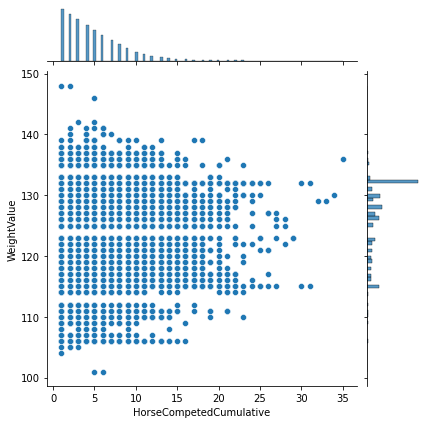

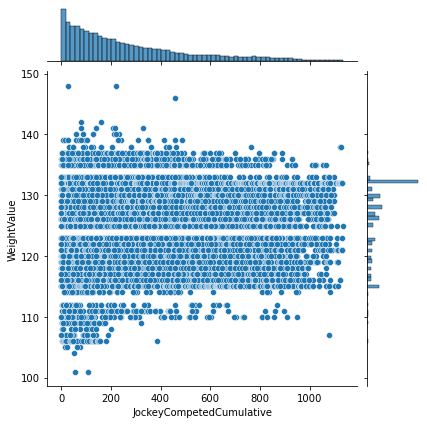

In [34]:
# Fairly balanced spread. Doesn't seem that higher weight values associated with experience (penalty0
sns.jointplot(data=horses_processed, y="WeightValue", x="HorseCompetedCumulative")
plt.show()

sns.jointplot(data=horses_processed, y="WeightValue", x="JockeyCompetedCumulative")
plt.show()


### Section 5: Statistical analysis
##### Section Aims
1. Identify and remove endogenous variables (corr, regression etc.)
2. Identify variables with little variable
3. Identify non-linear variables
4. Flag some possible predictors of Won for model explainability
5. Decide the features of interest/drop for modelling.

#### What are the features of interest to focus on during statistical analysis?
* Forecast Profit ratio (captures the odds) and Starting profit ratio.
* Age
* WeightValue
* Days since last run
* Horse count
* Horse wins (how many times has the horse won previously)
* Jockey wins (how many times has the jockey won previously)
* Trainer wins (how many winners in the trainer's stable before race)
* Sex
* Stall (might play a role on oval courses).


In [35]:
### We don't need to review features like HorseID or PKEY
sa_data = horses_processed[STAT_ANALYSIS_FEATURES]

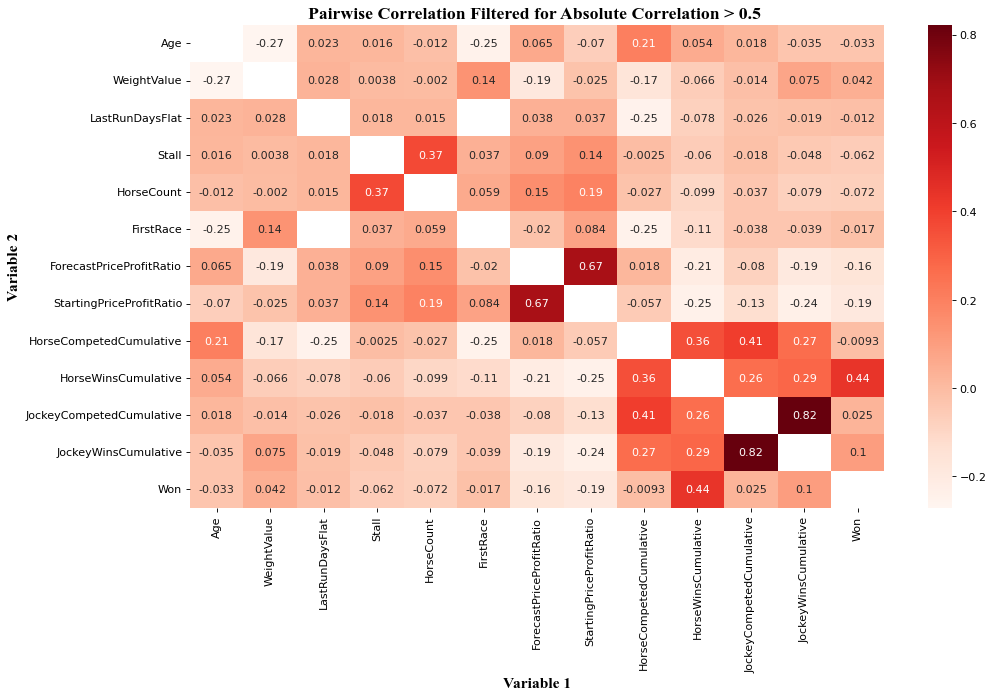

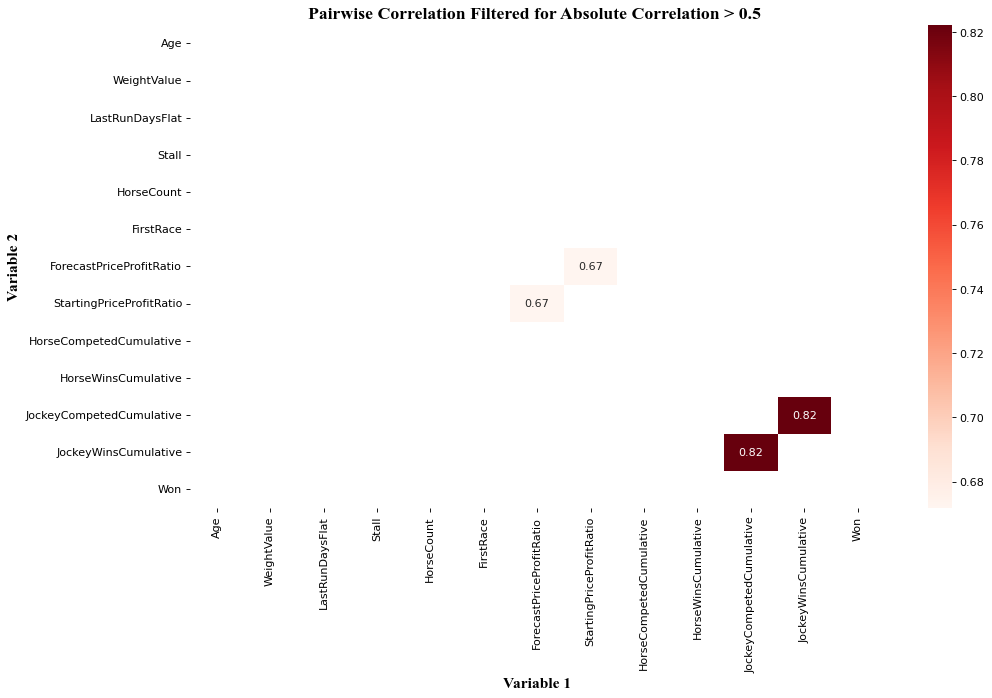

Feature  Correlation  AbsCorrelation
9        HorseWinsCumulative      0.43948         0.43948
7   StartingPriceProfitRatio     -0.18972         0.18972
6   ForecastPriceProfitRatio     -0.16239         0.16239
11      JockeyWinsCumulative      0.10264         0.10264
4                 HorseCount     -0.07192         0.07192
3                      Stall     -0.06191         0.06191
1                WeightValue      0.04245         0.04245
0                        Age     -0.03271         0.03271
10  JockeyCompetedCumulative      0.02512         0.02512
5                  FirstRace     -0.01711         0.01711
2            LastRunDaysFlat     -0.01213         0.01213
8    HorseCompetedCumulative     -0.00928         0.00928

In [36]:
# Pairwise correlation
plot_correlation_heatmap(sa_data)
plot_correlation_heatmap(sa_data,
                         positive_corr_limit=0.5,
                         negative_corr_limit=-0.5)

### Label correlation
won_corr = sa_data[sa_data.columns[1:]].corr()['Won'][:].to_frame().reset_index()
won_corr.columns = ['Feature', 'Correlation']
won_corr = won_corr[won_corr.Correlation < 1]
won_corr['AbsCorrelation'] = won_corr.Correlation.abs()
won_corr.sort_values('AbsCorrelation', inplace=True, ascending=False)
won_corr.round(5)

#### Correlation Analysis Notes:

##### Pairwise Correlation
* JockeyCompetedCumulative (number of races jockey has competed) shows a high positive correlation with the number of wins.
    * This makes sense as the more a Jockey competes, the more races they can win.
    * There may also be a selection bias at play where better jockeys are more in demand.
* ForecastProfitRatio shows a high positive correlation with StartingProfitRatio
    * Some of my research indicated that forecast is pre-race day and starting profit on the day
    * Therefore, it's likely that starting price (profit) is an adjusted forecast
    * Adjusted for new information.
    * So it follows that starting price will be close in value to the forecast.

##### Label Correlation
* The number of horse wins presents the strongest (+-) correlation with whether the horse wins a given race.
    * Possibly Explanation: winning races shows a solid ability to win races.
* There is a similar but weaker effect for Jockeys
    * Perhaps because Jockeys ride different horses with varying abilities, this diminishes the relationship between the number of wins and future wins.
* Startingprofit/ForecastProfit ratio negatively correlated with winning
    * Explanation is that bookmakers have good models for determining the probability of winning.
    * Therefore, bookmakers price horses less likely to win with better odds and the lower the odds, the lower the bookmaker's confidence
    * If we assume bookmakers have somewhat reliable models, this will explain the negative relationship
* Horsecount has a negative relationship.
    * Somewhat tautologous as more horses, lower probability of each horse winning (competition)
* Weight value shows a strong positive correlation, possibly due to performance-based handicap allocation.
* Age and Number of Races a horse has competed show a negative correlation
    * This may imply a negative experience penalty for horses (older, less likely to win)
    * Similarly, the first race has a negative correlation coefficient
* Jockey cumulative races show a positive correlation, which may indicate positive gains from the experience

### Non normality tests
* Instead of visually checking each numeric feature distribution
* A more rigorous approach is to use Shapiro-Wilks (SW) Test
* SW test fis normal distribution and calcs the sample dist +- deviations from fitted dist
* A summary stat is calculated, and it is evaluated against critical value
* If summary stat > critical value, we reject H0: sample distribution is not normal
* To help explain results, I have also looked at kurtosis and skew (key drivers of non-normality)

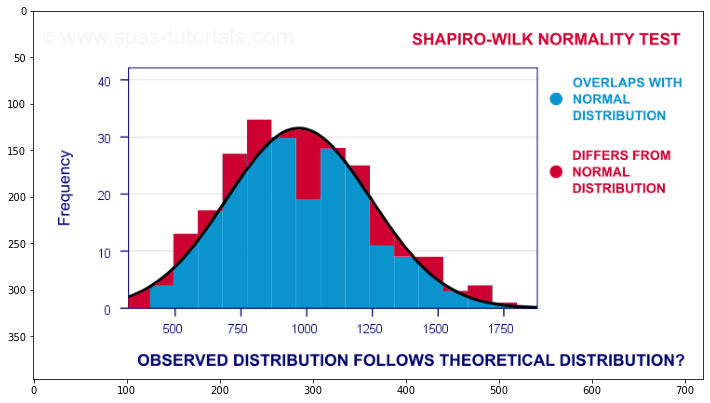

In [37]:
# Plotted using Python as using markdown was creating Latex issues when exporting. 
plt.figure(figsize=(12, 10))
img = mpimg.imread(os.path.join(IMAGE_FOLDER + "shapiro_wilk_test.png"))
imgplot = plt.imshow(img)
plt.show()

In [38]:
normal_cols = []
non_normal_cols = []

for col in sa_data.select_dtypes(include=NUMERIC_DATA_TYPES):
    #Ignore binary columns as these are by def not normal (only two vals)
    if col in ['Won', 'FirstRace']:
        pass
    else:
        stat, p = stats.shapiro(sa_data[col])
        alpha = 0.05

        if p > alpha:
            normal_cols.append(col)
        else:
            non_normal_cols.append(col)

print(Colour.BOLD + 'Passed: We can not Reject H0 that feature is normal' + Colour.END)
print(*normal_cols, sep='\n')
print('\n')

print(Colour.BOLD + 'Failed: We can Reject H0 that feature is normal' + Colour.END)
print(*non_normal_cols, sep='\n')

Passed: We can not Reject H0 that feature is normal
Age
LastRunDaysFlat
Stall
ForecastPriceProfitRatio
StartingPriceProfitRatio
JockeyCompetedCumulative
JockeyWinsCumulative


Failed: We can Reject H0 that feature is normal
WeightValue
HorseCount
HorseCompetedCumulative
HorseWinsCumulative


/opt/anaconda3/envs/starling_technical/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


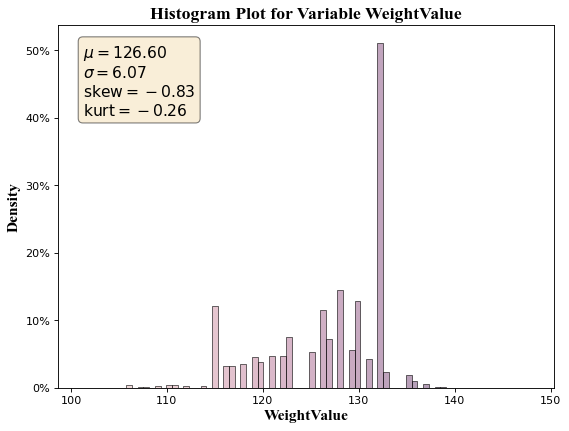

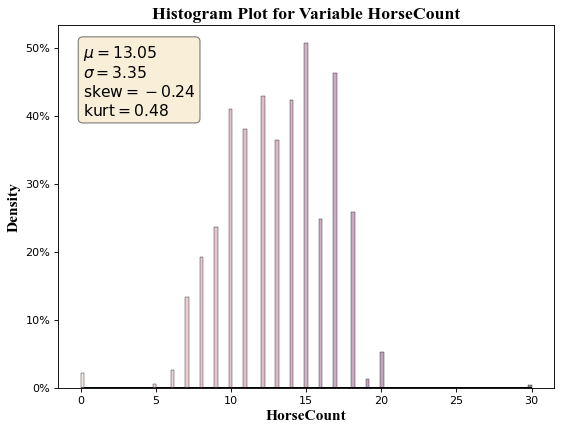

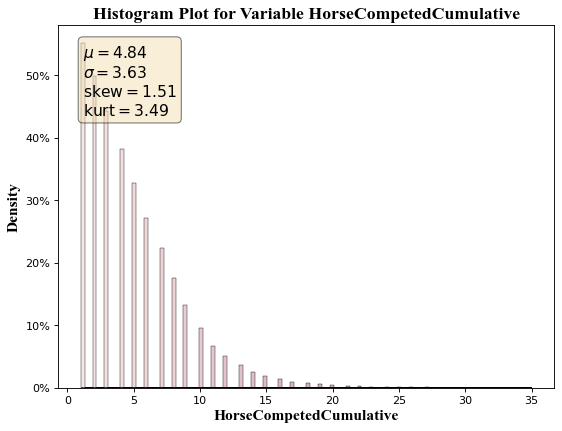

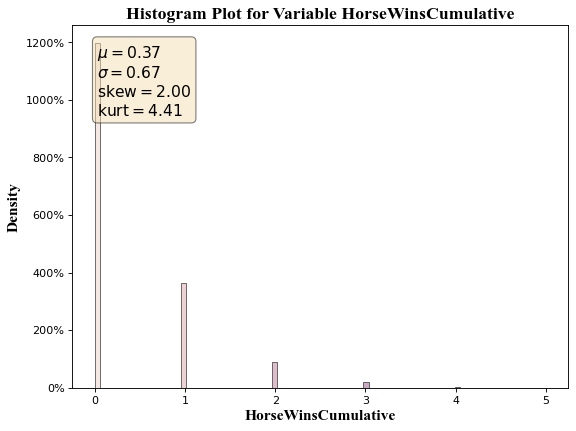

In [39]:
### Let's review the non-normal distributions with kurtosis and skew info
for non_normal_col in non_normal_cols:
    plot_continuous_histogram(sa_data,
                              non_normal_col,
                              show_plot=True)


#### Non-normality notes
* Weight value has negative kurtosis (quite rare...had to look this one up!)
    * Negative kurtosis can be treated as effectively 0.
    * Platykurtic distributions (dome) - flat dist, all values within dome, no real tails
    * Negative skew despite spike at 134 (handicap standard)
* HorseCount
    * Kurtosis is almost 0 therefore closer to platykurtic dist
    * Flatter peak and dome-like dist (little if any tails).
    * Indicates that distribution is capped on both sides
    * Which is likely from fact that horse races flats races very often have 8-22 horses
* HorseCompeted
    * Number races competed is actually normal in its kurtosis
    * However, it's very positively skewed because value < 0
    * We can fix this with a log transform.
* HorseWinsCumulative
    * Same as Horsecompeted but with a much smaller spread
    * Higher kurtosis shows leptokurtic tendency
    * This is probably more due to lack of values.
    * Might be able to fix this with log transform

/opt/anaconda3/envs/starling_technical/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


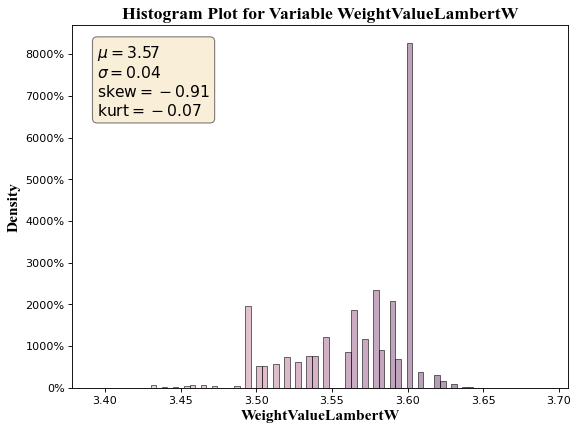

/opt/anaconda3/envs/starling_technical/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


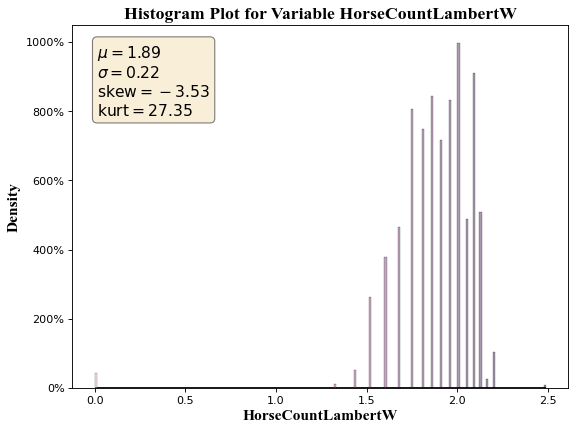

/opt/anaconda3/envs/starling_technical/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


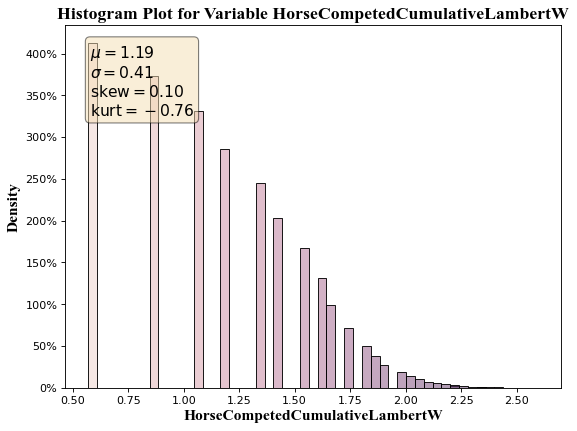

/opt/anaconda3/envs/starling_technical/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


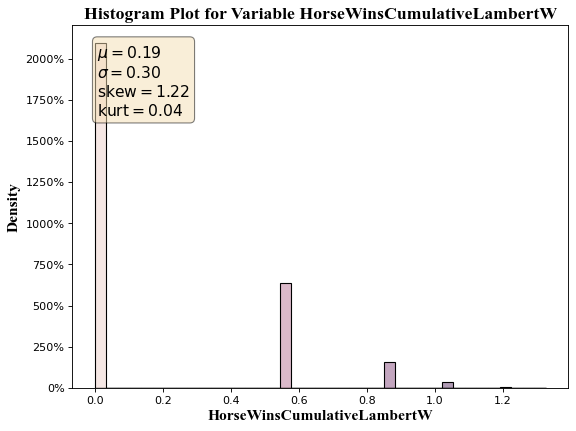

In [40]:
# Try Lambert transform and Log transform
for non_normal_col in non_normal_cols:
    horses_processed[non_normal_col + "LambertW"] = lambertw(horses_processed[non_normal_col]).astype(float)
    # PlotLambert W Transform
    plot_continuous_histogram(horses_processed,
                              non_normal_col+"LambertW")

    fig.tight_layout()

/var/folders/vf/_431qrjd2cl5v_78zcbwwlfh0000gp/T/ipykernel_87992/3750482462.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  horses_processed[non_normal_cols].fillna(


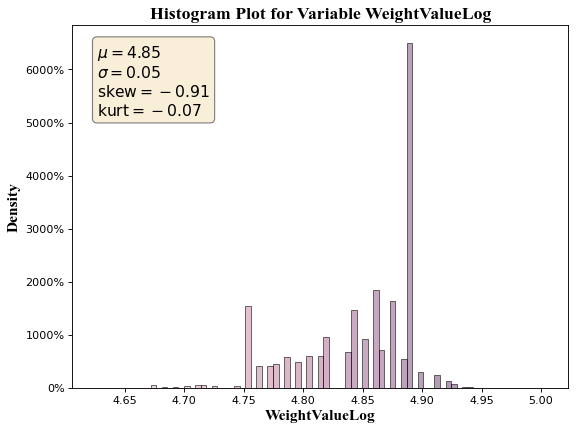

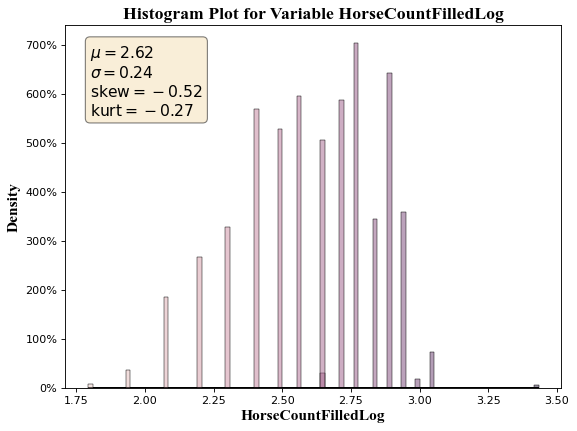

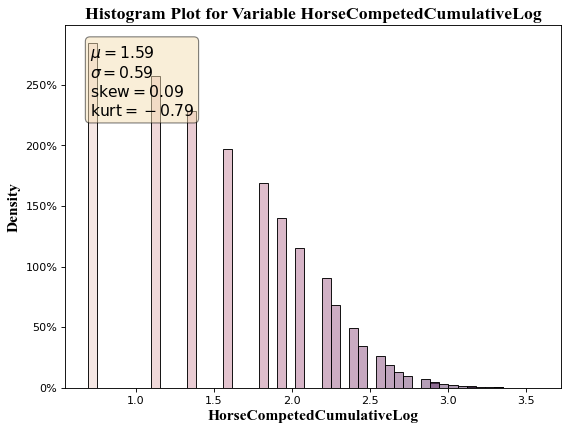

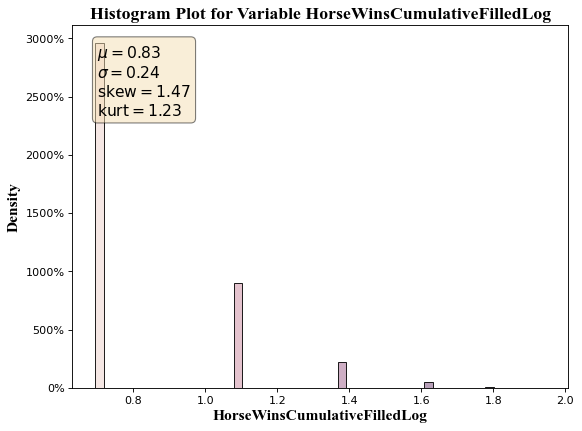

In [41]:
# Lambert didn't help. Try Log transform
# Replace 0 values with either mean or 1 depending on where appropriate to allow log transform
horses_processed["HorseCountFilled"] = np.where(horses_processed["HorseCount"] == 0,
                                                horses_processed["HorseCount"].mean(),
                                                horses_processed["HorseCount"])
horses_processed["HorseWinsCumulativeFilled"] = horses_processed.HorseWinsCumulative.add(1)

horses_processed[non_normal_cols].fillna(
    horses_processed[non_normal_cols].mean(),
    inplace=True)

# Update to include filled cols
non_normal_cols = [
    "WeightValue",
    "HorseCountFilled",
    "HorseCompetedCumulative",
    "HorseWinsCumulativeFilled"
]

for non_normal_col in non_normal_cols:
    horses_processed[non_normal_col + "Log"] = np.log(horses_processed[non_normal_col] + 1)
    plot_continuous_histogram(horses_processed,
                              non_normal_col +"Log")

    fig.tight_layout()

#### Non-normality notes
* Four features were identified as non-normal by the Shapiro-Wilks test.
* Both Lambert-W and Log transforms explored to reduce non-normality.
* Lambert-W failed to significantly reduce kurtosis and skew for non-normal features
* Log transform (in combination with some na/zero filling) did significantly reduce non-normality
* Decision to continue with log-transformed versions of non-normal features.

In [42]:
### Save output of stat analysis and feature creation to disk for modelling
print('End of Analysis. Saving Processed Horses Data to Disk for Modelling')
horses_processed.to_csv(HORSES_DATA_PROCESSED_PATH)

End of Analysis. Saving Processed Horses Data to Disk for Modelling
